In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

#Environment that evaluates operations immediately without creating graphs
tf.enable_eager_execution()


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

/home/monster/.keras/datasets/flower_photos


In [4]:
for item in data_root.iterdir():
  print(item)

/home/monster/.keras/datasets/flower_photos/LICENSE.txt
/home/monster/.keras/datasets/flower_photos/sunflowers
/home/monster/.keras/datasets/flower_photos/tulips
/home/monster/.keras/datasets/flower_photos/roses
/home/monster/.keras/datasets/flower_photos/dandelion
/home/monster/.keras/datasets/flower_photos/daisy


In [5]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [7]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

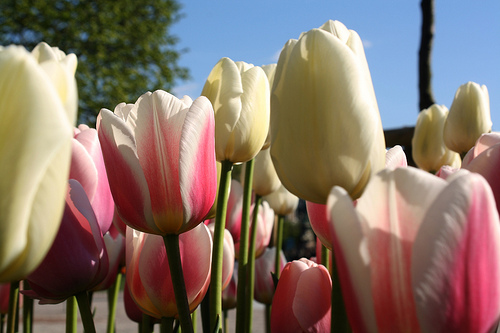

Image (CC BY 2.0)  by Blondinrikard Fröberg



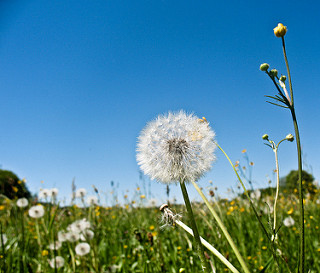

Image (CC BY 2.0)  by Alex Graves



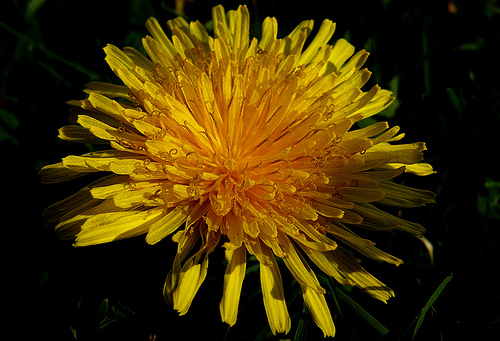

Image (CC BY 2.0)  by OliBac



In [8]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

In [9]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [10]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [11]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 0, 4, 0, 1, 2, 0, 2, 4, 4]


In [12]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [13]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [14]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(image_path))
plt.title(label_names[label].title())
plt.show()

<Figure size 640x480 with 1 Axes>

In [15]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [16]:
BATCH_SIZE = 32

ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [17]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=True

In [18]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobile_net.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobile_net.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [19]:
mobile_net.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [20]:
#Model expects its input to be normalized to the [-1,1] range:
#So before the passing it to the MobilNet model, we need to convert the input from a range of [0,1] to [-1,1].
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [21]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
#The MobileNet returns a 6x6 spatial grid of features for each image.
#Pass it a batch of images to see:

image_batch, label_batch = next(iter(keras_ds))

In [22]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [23]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [24]:
#model returns expected output
logit_batch = model(image_batch).numpy()

print("Shape:", logit_batch.shape)

Shape: (32, 5)


In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [26]:
len(model.trainable_variables)

58

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 1,868,997
Non-trainable params: 395,392
_________________________________________________________________


In [28]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [29]:
history =model.fit(ds, epochs=20, steps_per_epoch=steps_per_epoch)

Epoch 1/20
115/115==============================] - 22s 193ms/step - loss: 2.4607 - acc: 0.5361
Epoch 2/20
115/115==============================] - 6s 54ms/step - loss: 2.0021 - acc: 0.4812
Epoch 3/20
115/115==============================] - 6s 55ms/step - loss: 1.6941 - acc: 0.4530
Epoch 4/20
115/115==============================] - 6s 53ms/step - loss: 1.6324 - acc: 0.3399
Epoch 5/20
115/115==============================] - 6s 53ms/step - loss: 1.7233 - acc: 0.2609
Epoch 6/20
115/115==============================] - 6s 55ms/step - loss: 1.7707 - acc: 0.2473
Epoch 7/20
115/115==============================] - 6s 53ms/step - loss: 1.7283 - acc: 0.2185
Epoch 8/20
115/115==============================] - 6s 51ms/step - loss: 1.7404 - acc: 0.2503
Epoch 9/20
115/115==============================] - 6s 56ms/step - loss: 1.6094 - acc: 0.2731
Epoch 10/20
115/115==============================] - 6s 53ms/step - loss: 1.6120 - acc: 0.2728
Epoch 11/20
115/115==============================] - 6s 5

In [30]:
history.history.keys()

dict_keys(['loss', 'acc'])

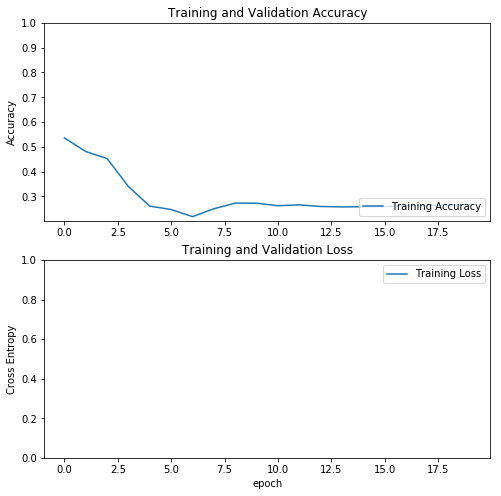

In [31]:
acc = history.history['acc']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Save-restore check points and models

In [ ]:
checkpoint_dir = '/home/monster/Gitprojects/Pretrained-models/chkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [ ]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print ('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                       model.optimizer.lr.numpy()))

In [ ]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),PrintLR()]

In [ ]:
history =model.fit(ds, epochs=20, steps_per_epoch=steps_per_epoch,callbacks=callbacks)

In [ ]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

eval_loss, eval_acc = model.evaluate(ds)
print ('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

In [ ]:
#save model and reload
'''This file includes:

The model's architecture
The model's weight values (which were learned during training)
The model's training config (what you passed to compile), if any
The optimizer and its state, if any (this enables you to restart training where you left off) '''

In [32]:
# Save the model
model.save('/home/monster/Gitprojects/Pretrained-models/saved_model/my_model1.h5')

# Recreate the exact same model purely from the file
new_model = tf.keras.models.load_model('/home/monster/Gitprojects/Pretrained-models/saved_model/my_model1.h5')

In [ ]:
eval_loss, eval_acc = new_model.evaluate(ds)
print ('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_acc))

In [33]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [34]:
new_model.fit(ds, epochs=20, steps_per_epoch=steps_per_epoch)

Epoch 1/20
115/115==============================] - 28s 243ms/step - loss: 1.6094 - acc: 0.2647
Epoch 2/20
115/115==============================] - 6s 53ms/step - loss: 1.6094 - acc: 0.2628
Epoch 3/20
115/115==============================] - 6s 53ms/step - loss: 1.6094 - acc: 0.2579
Epoch 4/20
115/115==============================] - 6s 52ms/step - loss: 1.6094 - acc: 0.2666
Epoch 5/20
115/115==============================] - 6s 54ms/step - loss: 1.6094 - acc: 0.2655
Epoch 6/20
115/115==============================] - 6s 54ms/step - loss: 1.6094 - acc: 0.2639
Epoch 7/20
115/115==============================] - 6s 52ms/step - loss: 1.6094 - acc: 0.2652
Epoch 8/20
115/115==============================] - 6s 52ms/step - loss: 1.6094 - acc: 0.2633
Epoch 9/20
115/115==============================] - 6s 52ms/step - loss: 1.6094 - acc: 0.2620
Epoch 10/20
115/115==============================] - 6s 53ms/step - loss: 1.6094 - acc: 0.2647
Epoch 11/20
115/115==============================] - 6s 5